In [1]:
# ==========================================
# Autonomous Drone Navigation via Approx Q-Learning
# ==========================================

import gymnasium as gym
from gym import spaces
import numpy as np
import cv2
import matplotlib.pyplot as plt
import random
import imageio
import os
from collections import deque
from base64 import b64encode
from IPython.display import HTML

# --- Part 1: Asset Management & Synthetic Data Generation ---


MAP_FILENAME = 'Cmap.png'
DRONE_FILENAME = 'Drone_image.jpg'

def create_dummy_assets():
    """Creates a synthetic map and drone sprite if files are missing."""
    if not os.path.exists(MAP_FILENAME):
        print("Creating dummy map...")
        img = np.ones((600, 600, 3), dtype=np.uint8) * 255

        pts = np.array([[50, 50], [550, 50], [550, 550], [50, 550]], np.int32)
        pts = pts.reshape((-1,1,2))
        cv2.polylines(img, [pts], True, (0,0,0), thickness=60)

        cv2.line(img, (300, 100), (300, 500), (0,0,0), 50)

        cv2.line(img, (100, 300), (500, 300), (0,0,0), 50)

        cv2.line(img, (100, 100), (500, 500), (0,0,0), 40)

        cv2.imwrite(MAP_FILENAME, img)

    if not os.path.exists(DRONE_FILENAME):
        print("Creating dummy ...")

        drone = np.zeros((64, 64, 4), dtype=np.uint8)

        cv2.circle(drone, (32, 32), 10, (255, 0, 0, 255), -1)
        cv2.circle(drone, (10, 10), 8, (0, 0, 255, 255), -1)
        cv2.circle(drone, (54, 10), 8, (0, 0, 255, 255), -1)
        cv2.circle(drone, (54, 54), 8, (0, 0, 255, 255), -1)
        cv2.circle(drone, (10, 54), 8, (0, 0, 255, 255), -1)
        cv2.line(drone, (10,10), (54,54), (100,100,100,255), 2)
        cv2.line(drone, (54,10), (10,54), (100,100,100,255), 2)

        cv2.imwrite(DRONE_FILENAME, drone)

create_dummy_assets()

# --- Part 2: The RL Environment ---

class DroneDeliveryEnv(gym.Env):
    metadata = {'render.modes': ['rgb_array']}

    def __init__(self, map_path, drone_path):
        super(DroneDeliveryEnv, self).__init__()

        self.original_map = cv2.imread(map_path)
        if self.original_map is None:
            raise ValueError("Map image not found!")

        # User Spec: Road is BLACK. Obstacles are Colored/White.
        # Converted to Grayscale
        gray = cv2.cvtColor(self.original_map, cv2.COLOR_BGR2GRAY)
        _, self.road_mask = cv2.threshold(gray, 60, 1, cv2.THRESH_BINARY_INV)
        self.h, self.w = self.road_mask.shape
        dist_transform = cv2.distanceTransform(self.road_mask, cv2.DIST_L2, 5)
        max_dist = np.max(dist_transform)
        road_width = max_dist * 2

        self.drone_size = int(road_width * 0.7)
        if self.drone_size < 10: self.drone_size = 10

        raw_drone = cv2.imread(drone_path, cv2.IMREAD_UNCHANGED)

        if len(raw_drone.shape) == 2:
            raw_drone = cv2.cvtColor(raw_drone, cv2.COLOR_GRAY2BGRA)
        elif raw_drone.shape[2] == 3:
            raw_drone = cv2.cvtColor(raw_drone, cv2.COLOR_BGR2BGRA)

        self.drone_sprite = cv2.resize(raw_drone, (self.drone_size, self.drone_size))

        # 3. Action Space (8-way movement)
        # 0:N, 1:NE, 2:E, 3:SE, 4:S, 5:SW, 6:W, 7:NW
        self.action_space = spaces.Discrete(8)
        self.moves = [(-1,0), (-1,1), (0,1), (1,1), (1,0), (1,-1), (0,-1), (-1,-1)]
        self.speed = int(road_width * 0.3) # Move 30% of road width per step

        self.start_pos = self._get_random_road_point()
        self.goal_pos = self._get_random_road_point()
        self.agent_pos = np.array(self.start_pos, dtype=float)

        self.max_steps = 500
        self.step_count = 0
        self.trajectory = []

    def _get_random_road_point(self):
        ys, xs = np.where(self.road_mask == 1)
        idx = np.random.randint(len(ys))
        return np.array([ys[idx], xs[idx]])

    def reset(self):
        self.agent_pos = np.array(self.start_pos, dtype=float)

        while True:
            self.goal_pos = self._get_random_road_point()
            if np.linalg.norm(self.goal_pos - self.agent_pos) > 100:
                break

        self.step_count = 0
        self.trajectory = [tuple(self.agent_pos.astype(int))]
        return self.agent_pos

    def step(self, action):
        self.step_count += 1
        dy, dx = self.moves[action]

        new_pos = self.agent_pos + np.array([dy, dx]) * self.speed
        ny, nx = new_pos.astype(int)

        reward = -1 # Living penalty
        done = False
        info = {}

        if not (0 <= ny < self.h and 0 <= nx < self.w):
            reward = -100
            done = True
            info['outcome'] = 'crash_boundary'
            return self.agent_pos, reward, done, info

        # Check Collision
        if self.road_mask[ny, nx] == 0:
            reward = -100
            done = True
            info['outcome'] = 'crash_wall'
            return self.agent_pos, reward, done, info

        self.agent_pos = new_pos
        self.trajectory.append((ny, nx))

        # Check Goal
        dist = np.linalg.norm(self.agent_pos - self.goal_pos)
        if dist < self.drone_size:
            reward = 100
            done = True
            info['outcome'] = 'success'

        if self.step_count >= self.max_steps:
            done = True
            info['outcome'] = 'timeout'

        return self.agent_pos, reward, done, info

    def render(self, mode='rgb_array'):
        canvas = self.original_map.copy()

        if len(self.trajectory) > 1:
            pts = np.array([self.trajectory], np.int32)
            swapped_pts = np.flip(pts, axis=2)
            cv2.polylines(canvas, swapped_pts, False, (0,0,255), 2)

        gy, gx = self.goal_pos
        cv2.circle(canvas, (gx, gy), 15, (0, 255, 0), -1)
        cv2.putText(canvas, "GOAL", (gx, gy-20), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0,255,0), 2)

        dy, dx = self.agent_pos.astype(int)
        h, w = self.drone_sprite.shape[:2]

        y1, y2 = dy - h//2, dy + h//2
        x1, x2 = dx - w//2, dx + w//2

        y1_c, y2_c = max(0, y1), min(self.h, y2)
        x1_c, x2_c = max(0, x1), min(self.w, x2)

        bg_h = y2_c - y1_c
        bg_w = x2_c - x1_c

        sy1 = y1_c - y1
        sx1 = x1_c - x1

        sy2 = sy1 + bg_h
        sx2 = sx1 + bg_w

        if y2_c > y1_c and x2_c > x1_c:
            sprite_crop = self.drone_sprite[sy1:sy2, sx1:sx2]
            bg_crop = canvas[y1_c:y2_c, x1_c:x2_c]

            alpha = sprite_crop[:, :, 3] / 255.0
            inv_alpha = 1.0 - alpha

            for c in range(3):
                bg_crop[:, :, c] = (alpha * sprite_crop[:, :, c] +
                                    inv_alpha * bg_crop[:, :, c])

            canvas[y1_c:y2_c, x1_c:x2_c] = bg_crop

        return canvas

# --- Part 3: Approximate Q-Learning Agent ---

class FeatureExtractor:
    def __init__(self, env):
        self.env = env
        self.dist_map = cv2.distanceTransform(env.road_mask, cv2.DIST_L2, 3)
        self.dist_map = self.dist_map / np.max(self.dist_map) # Normalize 0-1
        self.max_dist = np.sqrt(env.h**2 + env.w**2)

    def get_features(self, state, action):
        dy, dx = self.env.moves[action]
        next_pos = state + np.array([dy, dx]) * self.env.speed
        ny, nx = next_pos.astype(int)

        f_bias = 1.0

        valid_pos = (0 <= ny < self.env.h) and (0 <= nx < self.env.w)
        is_wall = False
        if valid_pos:
            if self.env.road_mask[ny, nx] == 0:
                is_wall = True
        else:
            is_wall = True

        f_crash = 1.0 if is_wall else 0.0

        if is_wall:
            dist = self.max_dist
        else:
            dist = np.linalg.norm(next_pos - self.env.goal_pos)

        f_dist = dist / self.max_dist

        f_safety = 0.0
        if valid_pos and not is_wall:
            f_safety = self.dist_map[ny, nx]

        return np.array([f_bias, f_dist, f_crash, f_safety])

class LinearQAgent:
    def __init__(self, env, alpha=0.01, gamma=0.95, epsilon=1.0):
        self.env = env
        self.alpha = alpha
        self.gamma = gamma
        self.epsilon = epsilon
        self.fe = FeatureExtractor(env)

        self.w = np.array([0.0, -1.0, -5.0, 0.5])

    def get_q(self, state, action):
        feats = self.fe.get_features(state, action)
        return np.dot(self.w, feats)

    def act(self, state):
        if np.random.rand() < self.epsilon:
            return self.env.action_space.sample()

        q_vals = [self.get_q(state, a) for a in range(8)]
        return np.argmax(q_vals)

    def update(self, state, action, reward, next_state, done):
        q_pred = self.get_q(state, action)

        if done:
            target = reward
        else:
            q_next = [self.get_q(next_state, a) for a in range(8)]
            target = reward + self.gamma * np.max(q_next)

        td_error = target - q_pred

        # Gradient update: w += alpha * error * features
        feats = self.fe.get_features(state, action)
        self.w += self.alpha * td_error * feats

# --- Part 4: Training & Video Rendering ---

def run_simulation():
    env = DroneDeliveryEnv(MAP_FILENAME, DRONE_FILENAME)
    agent = LinearQAgent(env)

    print("Training Agent (Approx 500 episodes)...")

    for ep in range(500):
        state = env.reset()
        done = False
        total_rew = 0

        while not done:
            action = agent.act(state)
            next_state, reward, done, info = env.step(action)
            agent.update(state, action, reward, next_state, done)
            state = next_state
            total_rew += reward

        # Decay Epsilon
        agent.epsilon = max(0.01, agent.epsilon * 0.99)

        if ep % 50 == 0:
            print(f"Ep {ep}: Reward={total_rew:.1f} Epsilon={agent.epsilon:.2f} Weights={agent.w}")

    # --- Render Final Video ---
    print("\nGenerating video of trained agent...")
    frames = []
    state = env.reset()
    agent.epsilon = 0.0 # Greedy mode
    done = False

    # Limit video length
    for _ in range(400):
        frame = env.render()
        frames.append(frame)

        action = agent.act(state)
        state, r, done, info = env.step(action)
        if done:
            # Add a few freeze frames at end
            for _ in range(10): frames.append(env.render())
            print(f"Final Run Result: {info['outcome']}")
            break

    # Save MP4
    video_path = 'drone_delivery_demo.mp4'
    imageio.mimsave(video_path, frames, fps=30)

    # Show in Notebook
    mp4 = open(video_path,'rb').read()
    data_url = "data:video/mp4;base64," + b64encode(mp4).decode()
    display(HTML(f"""
    <video width=600 controls autoplay loop>
          <source src="{data_url}" type="video/mp4">
    </video>
    """))
    print(f"Video saved to {video_path}")

if __name__ == "__main__":
    run_simulation()

Gym has been unmaintained since 2022 and does not support NumPy 2.0 amongst other critical functionality.
Please upgrade to Gymnasium, the maintained drop-in replacement of Gym, or contact the authors of your software and request that they upgrade.
See the migration guide at https://gymnasium.farama.org/introduction/migration_guide/ for additional information.


Creating dummy map...
Creating dummy ...
Training Agent (Approx 500 episodes)...
Ep 0: Reward=-110.0 Epsilon=0.99 Weights=[-1.02555072 -1.95810706 -5.93894227  0.46611122]


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


Ep 50: Reward=92.0 Epsilon=0.60 Weights=[-15.33249539 -24.35403651 -29.42926197   4.2408795 ]
Ep 100: Reward=91.0 Epsilon=0.36 Weights=[ -6.66466112 -31.6769175  -39.97801508   9.66496874]
Ep 150: Reward=-118.0 Epsilon=0.22 Weights=[  1.15678749 -37.37051699 -47.82100197   6.81887299]
Ep 200: Reward=-112.0 Epsilon=0.13 Weights=[  7.23704281 -42.82503118 -51.95167764   5.81855837]
Ep 250: Reward=-106.0 Epsilon=0.08 Weights=[ 12.46826117 -48.64677863 -54.60745535   5.37738891]
Ep 300: Reward=56.0 Epsilon=0.05 Weights=[ 23.8938836  -52.99320453 -55.73806671   8.96524723]
Ep 350: Reward=-79.0 Epsilon=0.03 Weights=[ 26.50597869 -58.50458084 -56.92053521   8.23112845]
Ep 400: Reward=85.0 Epsilon=0.02 Weights=[ 17.22052405 -65.03729363 -56.81931421   3.98034608]
Ep 450: Reward=-231.0 Epsilon=0.01 Weights=[ 17.19930894 -70.80987432 -56.37208383   3.84577006]

Generating video of trained agent...


Video saved to drone_delivery_demo.mp4


Training...
Episode    0 | Reward:  -50.10 | Epsilon: 1.000


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


Episode  200 | Reward:  -51.00 | Epsilon: 0.471
Episode  400 | Reward:  -53.00 | Epsilon: 0.173
Episode  600 | Reward:  -60.30 | Epsilon: 0.063
Episode  800 | Reward:  -85.50 | Epsilon: 0.050
Episode 1000 | Reward:  -54.50 | Epsilon: 0.050
Episode 1200 | Reward:  -51.60 | Epsilon: 0.050
Episode 1400 | Reward:  -57.40 | Epsilon: 0.050
Episode 1600 | Reward:  -51.50 | Epsilon: 0.050
Episode 1800 | Reward:  -55.20 | Epsilon: 0.050
Episode 2000 | Reward:  -51.60 | Epsilon: 0.050
Episode 2200 | Reward:  -62.10 | Epsilon: 0.050
Episode 2400 | Reward:  -94.40 | Epsilon: 0.050
Episode 2600 | Reward:  -54.70 | Epsilon: 0.050
Episode 2800 | Reward:  -53.20 | Epsilon: 0.050


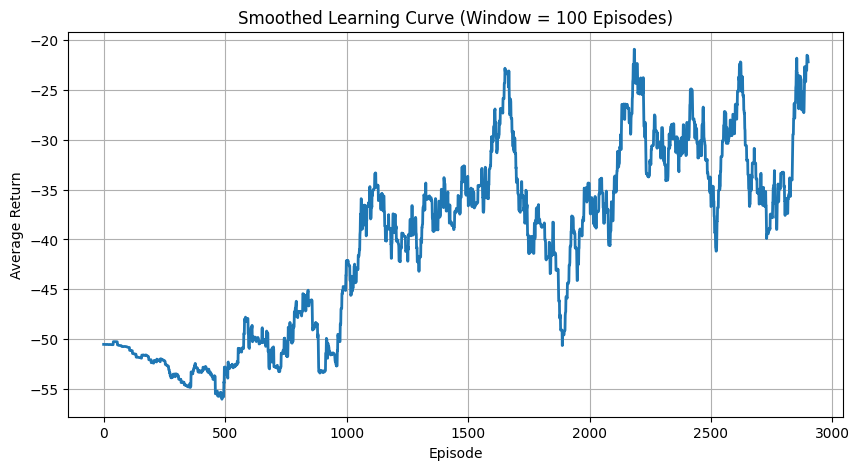


Rendering final rollout...
Mission ended: success
Video saved: drone_output.mp4


In [2]:
import os
import numpy as np
import cv2
import math
import random
import imageio
import matplotlib.pyplot as plt
from base64 import b64encode
from IPython.display import HTML, display

MAP_FILENAME = 'CityMap.jpg'
DRONE_FILENAME = 'Drone_image.jpg'
BIRD_SPRITE_PATH = 'Bird1.jpg'

# UTILITIES

def load_rgba(path):
    img = cv2.imread(path, cv2.IMREAD_UNCHANGED)
    if img is None:
        return None
    if len(img.shape) == 2:
        img = cv2.cvtColor(img, cv2.COLOR_GRAY2BGRA)
    elif img.shape[2] == 3:
        img = cv2.cvtColor(img, cv2.COLOR_BGR2BGRA)
    return img

def alpha_blend(bg, fg, x, y):
    """Overlay RGBA sprite fg onto bg at x,y."""
    h, w = bg.shape[:2]
    fh, fw = fg.shape[:2]
    x1, y1 = max(0, x), max(0, y)
    x2, y2 = min(w, x+fw), min(h, y+fh)
    if x2 <= x1 or y2 <= y1:
        return bg
    fg_crop = fg[y1-y:y1-y+(y2-y1), x1-x:x1-x+(x2-x1)]
    bg_crop = bg[y1:y2, x1:x2]
    alpha = fg_crop[:, :, 3:] / 255.0
    out = alpha * fg_crop[:, :, :3] + (1 - alpha) * bg_crop
    bg[y1:y2, x1:x2] = out.astype(np.uint8)
    return bg

def check_assets():
    if not os.path.exists(MAP_FILENAME):
        print("Map missing. Creating fallback.")
        dummy = np.ones((300,300,3), dtype=np.uint8)*255
        cv2.rectangle(dummy, (50,140), (250,160), (0,0,0), -1)
        cv2.imwrite(MAP_FILENAME, dummy)
    if not os.path.exists(DRONE_FILENAME):
        print("Drone missing. Creating fallback.")
        d = np.zeros((32,32,4), dtype=np.uint8)
        cv2.circle(d, (16,16), 15, (255,0,0,255), -1)
        cv2.imwrite(DRONE_FILENAME, d)
    if not os.path.exists(BIRD_SPRITE_PATH):
        print("Bird missing. Creating fallback sprite.")
        b = np.zeros((40,40,4), dtype=np.uint8)
        cv2.circle(b, (20,20), 18, (0,0,255,255), -1)
        cv2.imwrite(BIRD_SPRITE_PATH, b)

try:
    from scipy.ndimage import gaussian_filter
except:
    def gaussian_filter(arr, sigma):
        k = int(max(3, round(sigma*6)))
        if k%2==0: k+=1
        return cv2.GaussianBlur(arr, (k,k), sigma, sigma)

check_assets()

# BIRD CLASS

class Bird:
    def __init__(self, pos, sprite, speed=2.0, radius=8.0, jitter=0.3):
        self.pos = np.array(pos, dtype=float)
        angle = random.random()*2*np.pi
        self.v = np.array([math.sin(angle), math.cos(angle)], dtype=float)*speed
        self.speed = float(speed)
        self.radius = float(radius)
        self.jitter = float(jitter)
        self.sprite = sprite

    def step(self, env):
        ang = math.atan2(self.v[0], self.v[1])
        ang += random.gauss(0, self.jitter)
        self.v = np.array([math.sin(ang), math.cos(ang)], dtype=float)*self.speed
        new = self.pos + self.v
        ny, nx = int(new[0]), int(new[1])
        if not(0 <= ny < env.h and 0 <= nx < env.w) or env.road_mask[ny,nx] == 0:
            self.v *= -1
        self.pos += self.v
        self.pos[0] = np.clip(self.pos[0], 1, env.h-2)
        self.pos[1] = np.clip(self.pos[1], 1, env.w-2)
        if self.pos[0] < 1 or self.pos[0] >= env.h-1: self.v[0] *= -1
        if self.pos[1] < 1 or self.pos[1] >= env.w-1: self.v[1] *= -1

    def distance_to_point(self, pt):
        return float(np.linalg.norm(self.pos - np.array(pt)) - self.radius)

    def will_collide_next(self, pt_next):
        future = self.pos + self.v
        return np.linalg.norm(future - np.array(pt_next)) <= (self.radius + 1.0)

# WIND FIELD (STEADY, NO SHAKE)

class WindField:
    def __init__(self, h, w, low_res=28, smoothing_sigma=8.0):
        self.h, self.w = h, w
        self.low_res = low_res
        self.sigma = smoothing_sigma
        rng = np.random.RandomState(None)
        self.base_vy = rng.randn(low_res, low_res).astype(np.float32)
        self.base_vx = rng.randn(low_res, low_res).astype(np.float32)
        m = np.sqrt(self.base_vy**2 + self.base_vx**2) + 1e-8
        self.base_vy /= m
        self.base_vx /= m
        self._compute_static()
        self.advect_speed = 0.4
        self.amp = 0.15

    def _compute_static(self):
        vy = cv2.resize(self.base_vy, (self.w, self.h), cv2.INTER_CUBIC)
        vx = cv2.resize(self.base_vx, (self.w, self.h), cv2.INTER_CUBIC)
        vy = gaussian_filter(vy, self.sigma)
        vx = gaussian_filter(vx, self.sigma)
        m = np.sqrt(vy**2 + vx**2) + 1e-8
        self.static_vy = (vy / m).astype(np.float32)
        self.static_vx = (vx / m).astype(np.float32)
        self.time = 0.0

    def step_time(self, dt=1.0):
        self.time += dt

    def sample(self, y, x):
        sy = int((y + self.advect_speed*self.time) % self.h)
        sx = int((x + 0.7*self.advect_speed*self.time) % self.w)
        vy = float(self.static_vy[sy, sx])
        vx = float(self.static_vx[sy, sx])
        return np.array([vy * self.amp, vx * self.amp])

# DRONE ENVIRONMENT

import gymnasium as gym
from gym import spaces

class DroneEnvWindBirdsFixed(gym.Env):
    metadata = {'render.modes': ['rgb_array']}

    def __init__(self, map_path=MAP_FILENAME, drone_path=DRONE_FILENAME,
                 n_birds=10, bird_radius_range=(6,12), bird_speed_range=(1.0,3.0),
                 battery_max=1800, wind_battery_factor=0.0004,
                 wind_low_res=28, wind_sigma=8.0, wind_amp=0.15, wind_scale=0.08):
        super().__init__()

        self.original_map = cv2.imread(map_path)
        gray = cv2.cvtColor(self.original_map, cv2.COLOR_BGR2GRAY)
        _, rm = cv2.threshold(gray, 90, 1, cv2.THRESH_BINARY_INV)
        rm = cv2.morphologyEx(rm, cv2.MORPH_CLOSE, np.ones((7,7), np.uint8))
        self.road_mask = rm
        self.h, self.w = rm.shape

        raw_drone = load_rgba(drone_path)
        if raw_drone is None:
            raw_drone = np.zeros((32,32,4), dtype=np.uint8)
            cv2.circle(raw_drone, (16,16), 15, (255,0,0,255), -1)
        dt = cv2.distanceTransform((rm*255).astype(np.uint8), cv2.DIST_L2, 5)
        road_width = max(1, np.max(dt)*2)
        self.speed = int(road_width*0.35)
        self.drone_size = int(max(8, road_width*0.6))
        self.drone_sprite = cv2.resize(raw_drone, (self.drone_size, self.drone_size))

        self.action_space = spaces.Discrete(8)
        self.moves = [(-1,0), (-1,1), (0,1), (1,1), (1,0), (1,-1), (0,-1), (-1,-1)]

        ys, xs = np.where(rm == 1)
        self.fixed_start_pos = np.array([ys[int(len(ys)*0.15)], xs[int(len(xs)*0.15)]], dtype=float)
        self.agent_pos = self.fixed_start_pos.copy()
        self.goal_pos = self._rand_goal()

        self.max_battery = battery_max
        self.battery = float(battery_max)
        self.wind_battery_factor = wind_battery_factor
        self.battery_drain = 1.0

        self.n_birds = n_birds
        self.bird_sprite = load_rgba(BIRD_SPRITE_PATH)
        self.bird_speed_range = bird_speed_range
        self.bird_radius_range = bird_radius_range
        self.birds = []
        self._spawn_birds()

        self.wind_field = WindField(self.h, self.w, low_res=wind_low_res, smoothing_sigma=wind_sigma)
        self.wind_field.amp = wind_amp
        self.wind_scale = wind_scale

        self.visit_map = np.zeros((self.h, self.w), dtype=np.float32)
        self.trajectory = []
        self.step_count = 0
        self.max_steps = 900

    def _rand_goal(self):
        ys, xs = np.where(self.road_mask == 1)
        i = np.random.randint(len(ys))
        return np.array([ys[i], xs[i]], dtype=float)

    def _spawn_birds(self):
        ys, xs = np.where(self.road_mask == 1)
        self.birds = []
        idxs = np.random.choice(len(ys), self.n_birds)
        for i in idxs:
            p = (float(ys[i]), float(xs[i]))
            sp = random.uniform(*self.bird_speed_range)
            r = random.uniform(*self.bird_radius_range)
            self.birds.append(Bird(p, self.bird_sprite, sp, r))

    def reset(self):
        self.agent_pos = self.fixed_start_pos.copy()
        self.goal_pos = self._rand_goal()
        self.battery = float(self.max_battery)
        self.visit_map[:] = 0
        self.trajectory = [tuple(self.agent_pos.astype(int))]
        self._spawn_birds()
        self.wind_field.time = random.random()*40
        self.step_count = 0
        return self.agent_pos.copy()

    def step(self, action):
        self.step_count += 1
        dy, dx = self.moves[action]
        self.wind_field.step_time(1.0)
        for b in self.birds:
            b.step(self)

        raw_wind = self.wind_field.sample(self.agent_pos[0], self.agent_pos[1]) * self.wind_scale
        action_disp = np.array([dy, dx]) * self.speed

        def valid(pos):
            py, px = int(pos[0]), int(pos[1])
            return (0 <= py < self.h and 0 <= px < self.w and self.road_mask[py,px] == 1)

        final_pos = None
        final_wind = np.array([0.0, 0.0])

        for ws in [1.0, 0.5, 0.25, 0.1, 0.0]:
            pos = self.agent_pos + action_disp + raw_wind*ws
            if valid(pos):
                final_pos = pos
                final_wind = raw_wind*ws
                break

        if final_pos is None:
            pos = self.agent_pos + action_disp
            if valid(pos):
                final_pos = pos
                final_wind = np.array([0, 0])
            else:
                py, px = int(pos[0]), int(pos[1])
                if not(0 <= py < self.h and 0 <= px < self.w):
                    return self.agent_pos.copy(), -50, True, {'outcome': 'crash_boundary'}
                return self.agent_pos.copy(), -50, True, {'outcome': 'crash_wall'}

        self.agent_pos = final_pos
        ny, nx = int(final_pos[0]), int(final_pos[1])
        self.trajectory.append((ny, nx))

        y0, y1 = max(0, ny-5), min(self.h, ny+5)
        x0, x1 = max(0, nx-5), min(self.w, nx+5)
        self.visit_map[y0:y1, x0:x1] += 1

        dh = self.drone_size // 2
        pts = [(ny, nx), (ny-dh, nx-dh), (ny-dh, nx+dh), (ny+dh, nx-dh), (ny+dh, nx+dh)]
        for b in self.birds:
            for py, px in pts:
                if 0 <= py < self.h and 0 <= px < self.w:
                    if np.linalg.norm(np.array([py, px]) - b.pos) <= b.radius:
                        return self.agent_pos.copy(), -80, True, {'outcome': 'crash_bird'}

        if np.linalg.norm(self.agent_pos - self.goal_pos) < self.drone_size:
            wind_mag = np.linalg.norm(final_wind)
            self.battery -= (1.0 + self.wind_battery_factor*wind_mag)
            if self.battery <= 0:
                return self.agent_pos.copy(), -100, True, {'outcome': 'battery_dead'}
            return self.agent_pos.copy(), 100, True, {'outcome': 'success'}

        wind_mag = np.linalg.norm(final_wind)
        self.battery -= (1.0 + self.wind_battery_factor*wind_mag)
        if self.battery <= 0:
            return self.agent_pos.copy(), -100, True, {'outcome': 'battery_dead'}

        if self.step_count >= self.max_steps:
            return self.agent_pos.copy(), -0.1, True, {'outcome': 'timeout'}

        return self.agent_pos.copy(), -0.1, False, {}

    def render(self, mode='rgb_array', show_wind=True):
        canvas = self.original_map.copy()

        if len(self.trajectory) > 1:
            pts = np.array([self.trajectory], np.int32)
            pts = np.flip(pts, axis=2)
            cv2.polylines(canvas, pts, False, (255, 0, 0), 2)

        gy, gx = map(int, self.goal_pos)
        cv2.circle(canvas, (gx, gy), 10, (0, 200, 0), -1)
        cv2.putText(canvas, "GOAL", (gx, gy-14), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 200, 0), 2)

        for b in self.birds:
            size = int(b.radius*2.2)
            spr = cv2.resize(b.sprite, (size, size))
            by, bx = int(b.pos[0]), int(b.pos[1])
            canvas = alpha_blend(canvas, spr, bx-size//2, by-size//2)

        if show_wind:
            for y in range(0, self.h, 40):
                for x in range(0, self.w, 40):
                    v = self.wind_field.sample(y, x)
                    ARROW_SCALE = 50
                    ex = int(x + v[1] * ARROW_SCALE)
                    ey = int(y + v[0] * ARROW_SCALE)
                    cv2.arrowedLine(canvas, (x, y), (ex, ey), (0, 150, 150), 1)

        pct = int((self.battery / self.max_battery)*100)
        cv2.putText(canvas, f"BAT:{pct}%", (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 0.8, (50, 50, 255), 2)

        dy, dx = self.agent_pos.astype(int)
        h, w = self.drone_sprite.shape[:2]
        canvas = alpha_blend(canvas, self.drone_sprite, dx-w//2, dy-h//2)

        return canvas

# FEATURE EXTRACTOR

class FeatureExtractorWindFixed:
    def __init__(self, env):
        self.env = env
        dm = cv2.distanceTransform((env.road_mask*255).astype(np.uint8), cv2.DIST_L2, 3)
        self.dist_map = dm / (np.max(dm) + 1e-8)
        self.maxd = math.sqrt(env.h**2 + env.w**2)

    def get_features(self, state, action):
        sy, sx = state.astype(float)
        dy, dx = self.env.moves[action]
        next_nom = state + np.array([dy, dx]) * self.env.speed
        wind_next = self.env.wind_field.sample(next_nom[0], next_nom[1]) * self.env.wind_scale
        next_pos = next_nom + wind_next
        ny, nx = int(next_pos[0]), int(next_pos[1])

        f_bias = 1.0

        # Crash penalty
        crash = 0 if (0 <= ny < self.env.h and 0 <= nx < self.env.w and self.env.road_mask[ny,nx] == 1) else 1
        f_crash = float(crash)

        # Distance to goal
        dist = self.maxd if crash else np.linalg.norm(next_pos - self.env.goal_pos)
        f_dist = dist / self.maxd

        # distance from obstacles
        f_safety = 0.0 if crash else float(self.dist_map[ny, nx])

        # Over-exploration penalty
        f_visited = 0.0
        if 0 <= ny < self.env.h and 0 <= nx < self.env.w:
            f_visited = min(self.env.visit_map[ny, nx], 10) / 10

        # Battery
        f_battery = self.env.battery / self.env.max_battery

        # Wind magnitude
        wind_mag = np.linalg.norm(wind_next)
        f_wind = wind_mag / self.maxd

        # Wind alignment (reduced penalty for better pathfinding)
        act_vec = np.array([dy, dx])
        if np.linalg.norm(act_vec) < 1e-6 or np.linalg.norm(wind_next) < 1e-6:
            align = 0
        else:
            align = float(np.dot(act_vec / np.linalg.norm(act_vec),
                                 wind_next / np.linalg.norm(wind_next)))
        f_align = -align * 0.5  # Reduced from -align

        # Bird avoidance
        dlist = [b.distance_to_point((ny, nx)) for b in self.env.birds]
        f_bird = min(dlist) / self.maxd if dlist else 1.0

        # Bird prediction
        f_pred = float(any(b.will_collide_next(next_pos) for b in self.env.birds))

        return np.array([
            f_bias, f_dist, f_crash, f_safety,
            f_visited, f_battery, f_wind,
            f_align, f_bird, f_pred
        ], dtype=np.float32)

# Q-LEARNING AGENT (BETTER WEIGHTS)

class LinearQAgentWindFixed:
    def __init__(self, env, alpha=0.02, gamma=0.97, epsilon=1.0):
        self.env = env
        self.alpha = alpha
        self.gamma = gamma
        self.epsilon = epsilon
        self.fe = FeatureExtractorWindFixed(env)

        # IMPROVED WEIGHTS: Better goal-seeking, less wind sensitivity
        self.w = np.array([
            0.5,      # bias
            -4.0,     # distance to goal (INCREASED penalty)
            -25.0,    # crash (INCREASED penalty)
            1.2,      # safety (INCREASED reward)
            -1.5,     # visited (reduced penalty)
            4.0,      # battery (reward staying alive)
            -1.0,     # wind (REDUCED penalty, was -5.0)
            1.0,      # alignment (reduced from 4.5, less fighting wind)
            -1.0,     # bird distance (reduced from -2.5)
            -40.0     # bird prediction (increased penalty)
        ], dtype=np.float32)

    def get_q(self, s, a):
        return float(np.dot(self.w, self.fe.get_features(s, a)))

    def act(self, s):
        if random.random() < self.epsilon:
            return self.env.action_space.sample()
        return int(np.argmax([self.get_q(s, a) for a in range(8)]))

    def update(self, s, a, r, s2, done):
        q = self.get_q(s, a)
        if done:
            tgt = r
        else:
            qn = max(self.get_q(s2, x) for x in range(8))
            tgt = r + self.gamma * qn
        td = tgt - q
        feats = self.fe.get_features(s, a)
        self.w += self.alpha * td * feats

# TRAINING & VISUALIZATION

def run_simulation(episodes=800, n_birds=8, wind_amp=0.10, wind_scale=0.08):
    env = DroneEnvWindBirdsFixed(
        n_birds=n_birds,
        wind_amp=wind_amp,
        wind_scale=wind_scale
    )

    agent = LinearQAgentWindFixed(env)

    episode_rewards = []
    episode_lengths = []

    print("Training...")
    for ep in range(episodes):
        s = env.reset()
        done = False
        total_reward = 0.0
        steps = 0

        while not done:
            a = agent.act(s)
            s2, r, done, _ = env.step(a)
            agent.update(s, a, r, s2, done)
            s = s2
            total_reward += r
            steps += 1

        episode_rewards.append(total_reward)
        episode_lengths.append(steps)

        if ep > 50:
            agent.epsilon = max(0.05, agent.epsilon * 0.995)

        if ep % 200 == 0:
            print(f"Episode {ep:4d} | Reward: {total_reward:7.2f} | Epsilon: {agent.epsilon:.3f}")


    # PLOT LEARNING CURVES

    def moving_average(x, w=100):
      return np.convolve(x, np.ones(w)/w, mode='valid')
    plt.figure(figsize=(10,5))
    plt.plot(moving_average(episode_rewards, 100), linewidth=2)
    plt.xlabel("Episode")
    plt.ylabel("Average Return")
    plt.title("Smoothed Learning Curve (Window = 100 Episodes)")
    plt.grid(True)
    plt.show()


    # FINAL ROLLOUT

    print("\nRendering final rollout...")
    frames = []
    s = env.reset()
    agent.epsilon = 0
    done = False

    for _ in range(1200):
        frames.append(env.render())
        a = agent.act(s)
        s, _, done, info = env.step(a)
        if done:
            print(f"Mission ended: {info.get('outcome')}")
            for _ in range(25):
                frames.append(env.render())
            break

    path = "drone_output.mp4"
    imageio.mimsave(path, frames, fps=30)
    print(f"Video saved: {path}")

    mp4 = open(path, "rb").read()
    display(HTML(f"""
    <h3>Mission Replay</h3>
    <video width=700 controls autoplay loop>
        <source src="data:video/mp4;base64,{b64encode(mp4).decode()}" type="video/mp4">
    </video>
    """))

    return episode_rewards, episode_lengths

if __name__ == "__main__":
    run_simulation(episodes=3000, n_birds=8, wind_amp=0.10, wind_scale=0.08)

